# Import libraries

In [190]:
import torch
import torch.nn as nn
import json
import numpy as np
from PIL import Image
import torchvision.transforms as T
import cv2
import scipy.sparse as sps
import scipy.sparse.linalg as linalg
import matplotlib.pyplot as plt
from argparse import Namespace
import kornia.filters as ft
import pyamg
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

In [191]:
def plots_all(*images):
    if len(images) != 1:
        count_images = [isinstance(image, np.ndarray) for image in images]
        images_ = [image for is_image, image in zip(count_images, images) if is_image]
        fig, axs = plt.subplots(1, sum(count_images),
                               figsize=(14, 10),
                               tight_layout=True)
        for ax, image in zip(axs, images_):
            if isinstance(image, np.ndarray):
                if image.shape[0] == 1:
                    image = image.squeeze()
                ax.imshow(image, cmap="gray")
                # ax.set_axis_off()
    else:
        plt.figure(figsize=(14, 10))
        image = images[0]
        if image.shape[0] == 1:
            image = image.squeeze()
        plt.imshow(image, cmap="gray")
    plt.show()

In [192]:
opt = Namespace(
    config_file = "../config/config_target_position_.json",
    target_file = "../images/new_target_one_.jpg",
    image_file = "../images/new_source_img_.jpg",
    mask_file = "../images/new_mask_img_.jpg"
)

In [193]:
def load_data(opt):
    image_data = {}
    source = np.array(Image.open(opt.image_file).convert("RGB"))
    mask = np.array(Image.open(opt.mask_file).convert("L"))
    target = np.array(Image.open(opt.target_file).convert("RGB"))
    
    # Get dimensions blending
    w_start, h_start = json.load(open(opt.config_file)).values()
    # w_start, h_start = w_start, h_start - 10
    # h, w = mask.shape
    
    # normalize the images
    # image_data['source'] = cv2.normalize(source.astype('float'), None, alpha=0.0, beta=1.0, norm_type=cv2.NORM_MINMAX)
    # image_data['mask'] = cv2.normalize(mask.astype('float'), None, alpha=0.0, beta=1.0, norm_type=cv2.NORM_MINMAX)
    # image_data['target'] = cv2.normalize(target.astype('float'), None, alpha=0.0, beta=1.0, norm_type=cv2.NORM_MINMAX)
    image_data['source'] = source/255.0
    image_data['mask'] = mask/255.0
    image_data['target'] = target/255.0
    image_data['dims'] = [h_start, w_start]
    
    return image_data

In [194]:
def preprocess(image_data):
    source = image_data['source']
    mask = image_data['mask']
    target = image_data['target']
    
    # Get Image shape and offset
    hs, ws, _ = source.shape
    ht, wt, _ = target.shape
    h0, w0 = image_data['dims']
    
    # Mask region on target
    h_min = h0
    h_max = h0 + hs
    w_min = w0
    w_max = w0 + ws
    
    return {'source': source, 'mask': mask, 'target': target, 'dims': [h_min, h_max, w_min, w_max]}

In [195]:
def get_subimg(image, dims):
    return image[dims[0]:dims[1], dims[2]:dims[3]]

# Images

In [196]:
image_data = load_data(opt)

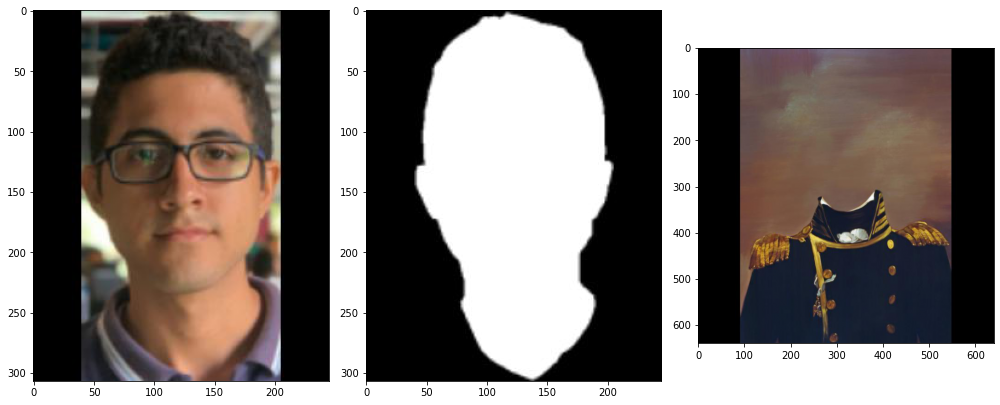

In [197]:
plots_all(*image_data.values())

 # Poisson Blending

## Preprocess Data

In [198]:
image_data = preprocess(image_data)

## Utility functions

In [199]:
def poisson_blending(image, GRAD_MIX):
    # comparison function
    def _compare(val1, val2):
        if(abs(val1) > abs(val2)):
            return val1
        else:
            return val2

    # membrane (region where Poisson blending is performed)
    mask = image['mask']
    Hs,Ws = mask.shape
    num_pxls = Hs * Ws

    # source and target image
    source = image['source'].flatten(order='C')
    target_subimg = get_subimg(image['target'], image['dims']).flatten(order='C')

    # initialise the mask, guidance vector field and laplacian
    mask = mask.flatten(order='C')
    guidance_field = np.empty_like(mask)
    laplacian = sps.lil_matrix((num_pxls, num_pxls), dtype='float64')

    for i in range(num_pxls):
        # construct the sparse laplacian block matrix
        # and guidance field for the membrane
        if(mask[i] > 0.99):

            laplacian[i, i] = 4
            # construct laplacian, and compute source and target gradient in mask
            if(i - Ws > 0):
                laplacian[i, i-Ws] = -1
                Np_up_s = source[i] - source[i-Ws]
                Np_up_t = target_subimg[i] - target_subimg[i-Ws]
            else:
                Np_up_s = source[i]
                Np_up_t = target_subimg[i]

            if(i % Ws != 0):
                laplacian[i, i-1] = -1
                Np_left_s = source[i] - source[i-1]
                Np_left_t = target_subimg[i] - target_subimg[i-1]
            else:
                Np_left_s = source[i]
                Np_left_t = target_subimg[i]

            if(i + Ws < num_pxls):
                laplacian[i, i+Ws] = -1
                Np_down_s = source[i] - source[i+Ws]
                Np_down_t = target_subimg[i] - target_subimg[i+Ws]
            else:
                Np_down_s = source[i]
                Np_down_t = target_subimg[i]

            if(i % Ws != Ws-1):
                laplacian[i, i+1] = -1
                Np_right_s = source[i] - source[i+1]
                Np_right_t = target_subimg[i] - target_subimg[i+1]
            else:
                Np_right_s = source[i]
                Np_right_t = target_subimg[i]

            # choose stronger gradient
            if(GRAD_MIX is False):
                Np_up_t = 0
                Np_left_t = 0
                Np_down_t = 0
                Np_right_t = 0

            guidance_field[i] = (_compare(Np_up_s, Np_up_t) + _compare(Np_left_s, Np_left_t) + 
                               _compare(Np_down_s, Np_down_t) + _compare(Np_right_s, Np_right_t))

        else:
            # if point lies outside membrane, copy target function
            laplacian[i, i] = 1
            guidance_field[i] = target_subimg[i]

    return [laplacian, guidance_field]

In [203]:
def linlnsq_solver(A, b, dims):
    x = linalg.spsolve(A.tocsc(), b)
    x = x.reshape(*dims)
    x = x.clip(0.0, 1.0)
    return x

def stitch_images(source, target, dims):
    solution = target.copy()
    solution[dims[0]: dims[1], dims[2]: dims[3], :] = source
    return solution

def blend_image(image_data, GRAD_MIX):
    equation_param = []
    ch_img_data = {}
    guidance_ch = []
    
    # Construc possion equation
    for ch in range(3):
        ch_img_data['source'] = image_data['source'][:, :, ch]
        ch_img_data['mask'] = image_data['mask']
        ch_img_data['target'] = image_data['target'][:, :, ch]
        ch_img_data['dims'] = image_data['dims']
        laplacian, guidence_field = poisson_blending(ch_img_data, GRAD_MIX)
        guidance_ch.append(guidence_field.reshape(image_data['mask'].shape))
        equation_param.append([laplacian, guidence_field])
        
    plots_all(*guidance_ch)
    image_solution = np.empty_like(image_data['source'])
    for ch in range(3):
        image_solution[:, :, ch] = linlnsq_solver(equation_param[ch][0], equation_param[ch][1],
                                                 image_data['mask'].shape)
    image_solution = stitch_images(image_solution, image_data['target'], image_data['dims'])
    return image_solution

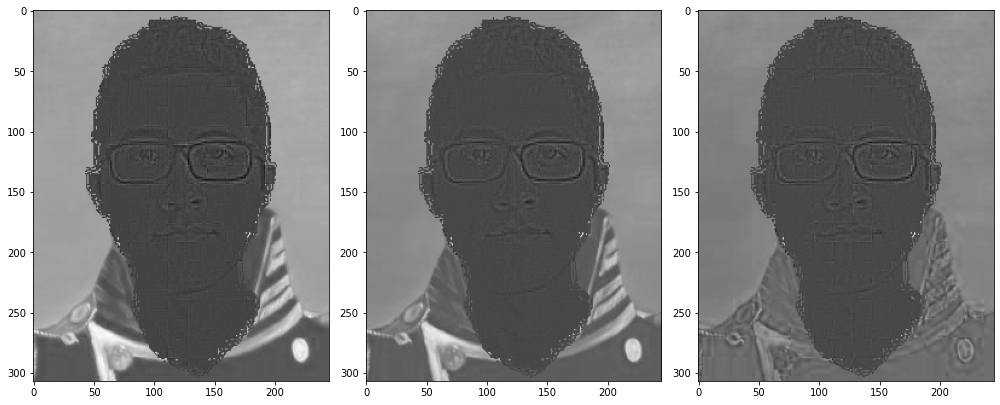

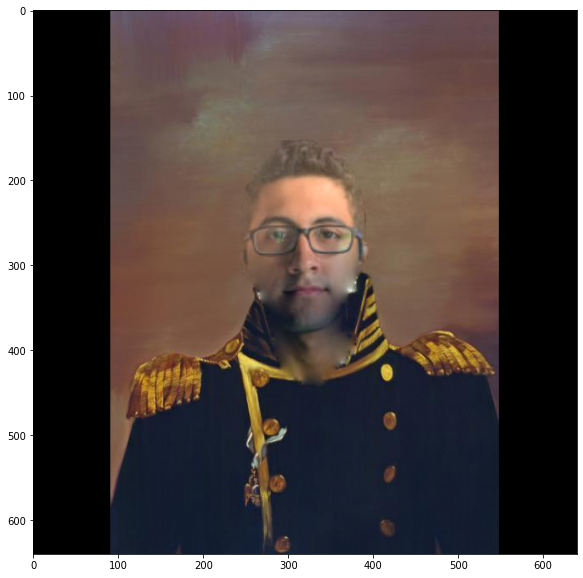

In [204]:
blended_image = blend_image(image_data, False)
plots_all(blended_image)

# Poisson Blending Using laplacian filters

In [205]:
def make_canvas_mask(image_data):
    dims = image_data['dims']
    target = image_data['target']
    mask = image_data['mask']
    canvas_mask = np.zeros(shape=target.shape[:-1])
    canvas_mask[dims[0]:dims[1], dims[2]:dims[3]] = mask
    return canvas_mask

In [206]:
image_data['canvas_mask'] = make_canvas_mask(image_data)
preprocess_source = np.zeros_like(image_data['target'])
dims = image_data['dims']
preprocess_source[dims[0]:dims[1], dims[2]:dims[3]] = image_data['source']
image_data['preprocess_source'] = preprocess_source

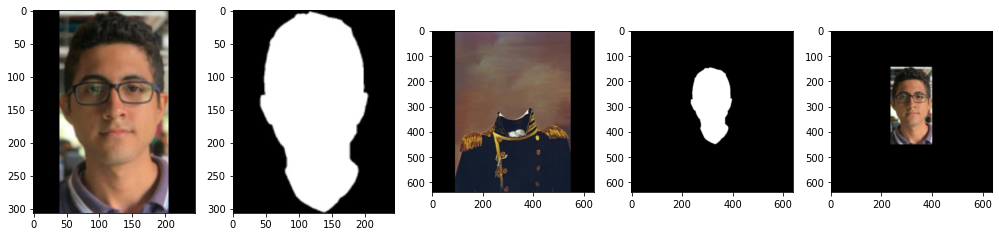

In [207]:
plots_all(*image_data.values())

In [281]:
def is_mask_pixel(mask, i, j):
    return mask[i, j] > 0.99

def new_poisson_blending(image_data):
    # membrane (region where Poisson blending is performed)
    mask = image_data['canvas_mask']
    Hs, Ws = mask.shape
    num_pxls = Hs * Ws

    # source and target image
    source = image_data['preprocess_source']
    target = image_data['target']
    
    # Create coefficient sparse matrix
    A = sps.identity(num_pxls, format='lil')
    for y in range(Hs):
        for x in range(Ws):
            if is_mask_pixel(mask, y, x):
                index = x + y * Ws
                A[index, index] = 4
                if index + 1 < num_pxls:
                    A[index, index + 1] = -1
                if index - 1 >= 0:
                    A[index, index - 1] = -1
                if index + Ws < num_pxls:
                    A[index, index + Ws] = -1
                if index - Ws >= 0:
                    A[index, index - Ws] = -1
    A = A.tocsr()
    
    # Create a poisson matrix for b
    P = pyamg.gallery.poisson((Hs, Ws))
    
    source = source.flatten()
    target = target.flatten()
    
    b = P * source.flatten()
    
    for y in range(Hs):
        for x in range(Ws):
            if not is_mask_pixel(mask, y, x):
                index = x + y * Ws
                b[index] = target[index]

    return [A, b]

In [299]:
def laplacian_filter_tensor(img_tensor):
    
    laplacian_filter = np.array([[0, -1, 0],[-1, 4, -1],[0, -1, 0]], dtype=np.float64)
    # laplacian_filter = np.array([[0, 1, 0],[1, 4, 1],[0, 1, 0]], dtype=np.float64)
    
    laplacian_conv = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
    laplacian_conv.weight = nn.Parameter(torch.from_numpy(laplacian_filter).unsqueeze(0).unsqueeze(0))
                                         
    for param in laplacian_conv.parameters():
        param.requires_grad = False

    red_img_tensor = img_tensor[:,0,:,:].unsqueeze(1)
    green_img_tensor = img_tensor[:,1,:,:].unsqueeze(1)
    blue_img_tensor = img_tensor[:,2,:,:].unsqueeze(1)

    red_gradient_tensor = laplacian_conv(red_img_tensor).squeeze(1) 
    green_gradient_tensor = laplacian_conv(green_img_tensor).squeeze(1) 
    blue_gradient_tensor = laplacian_conv(blue_img_tensor).squeeze(1)

    return red_gradient_tensor, green_gradient_tensor, blue_gradient_tensor
    

def sobel_filter_tensor(img_tensor):
    
    # Define directional kernels
    x_kernel = torch.tensor([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ], dtype = torch.float64)
    y_kernel = torch.tensor([
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]
    ], dtype = torch.float64)
    
    # Define convolutionals
    x_convolution = nn.Conv2d(1, 1, kernel_size=6, stride=1, padding=1, bias=False)
    x_convolution.weight = nn.Parameter(x_kernel.unsqueeze(0).unsqueeze(0))
    y_convolution = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
    y_convolution.weight = nn.Parameter(y_kernel.unsqueeze(0).unsqueeze(0))
    
    # Set requires grad false
    for param_x, param_y in zip(x_convolution.parameters(), y_convolution.parameters()):
        param_x.requires_grad = False
        param_y.requires_grad = False
        
    
    # get convolutional for earch image channel
    rgb_img_gradient = []
    for ch in range(3):
        ch_img_tensor = img_tensor[:, ch, :, :].unsqueeze(1)
        gx_ch_img_gradient = x_convolution(ch_img_tensor)
        gy_ch_img_gradient = y_convolution(ch_img_tensor)
        ch_img_gradient = torch.sqrt(gx_ch_img_gradient**2 + gy_ch_img_gradient**2).squeeze(0)
        rgb_img_gradient.append(ch_img_gradient)
        
    return rgb_img_gradient
    
                                         
def compute_blending_gradient(image_data, alpha=0.5, plots=False):
    # Get data
    source = image_data['preprocess_source']
    mask = image_data['canvas_mask']
    target = image_data['target']
    dims = image_data['dims']
    
    # Get membrane
    # target_subimg = get_subimg(target, dims)
    target_subimg = target
    
    # compute source image gradient
    source = torch.from_numpy(np.transpose(source, (2, 0, 1))).unsqueeze(0)
    rs_gradient, gs_gradient, bs_gradient = [gradient.numpy()[0] for gradient in laplacian_filter_tensor(source)]
    
    # compute target image gradient
    target_subimg = torch.from_numpy(np.transpose(target_subimg, (2, 0, 1))).unsqueeze(0)
    rt_gradient, gt_gradient, bt_gradient = [target_subimg[:, ch, :, :].numpy()[0] for ch in range(3)]
    # rt_gradient, gt_gradient, bt_gradient = [gradient.numpy()[0] for gradient in laplacian_filter_tensor(target_subimg)]
    
    # foreground gradients
    rsf_gradient = rs_gradient * mask
    gsf_gradient = gs_gradient * mask
    bsf_gradient = bs_gradient * mask
    
    # background gradients
    rtb_gradient = rt_gradient - rt_gradient * mask
    gtb_gradient = gt_gradient - gt_gradient * mask
    btb_gradient = bt_gradient - bt_gradient * mask
    
    # Poisson mixing gradient
    # r_blending_gradient = rsf_gradient * (alpha) + rtb_gradient * (1 - alpha)
    # g_blending_gradient = gsf_gradient * (alpha) + gtb_gradient * (1 - alpha)
    # b_blending_gradient = bsf_gradient * (alpha) + btb_gradient * (1 - alpha)
    r_blending_gradient = rsf_gradient + rtb_gradient 
    g_blending_gradient = gsf_gradient + gtb_gradient 
    b_blending_gradient = bsf_gradient + btb_gradient 
    
    
    # plots source gradient
    if plots:
        # plots_all(rs_gradient, gs_gradient, bs_gradient)
        # plots_all(rt_gradient, gt_gradient, bt_gradient)
        # plots_all(rtb_gradient, gtb_gradient, btb_gradient)
        # plots_all(rsf_gradient, gsf_gradient, bsf_gradient)
        plots_all(r_blending_gradient, g_blending_gradient, b_blending_gradient)
    return r_blending_gradient, g_blending_gradient, b_blending_gradient

In [312]:
def solver_poisson(A, b, dims):
    x = pyamg.solve(A, b, verb=False, tol=1e-10)
    x = x.reshape(*dims)
    x = x.clip(0.0, 1.0)
    return x
    
def new_blend_image(image_data, alpha=0.5, plots=False):
    equation_param = []
    ch_img_data = {}
    b_gradient_ch = []
    
    b_temp_gradient_ch = compute_blending_gradient(image_data, alpha=alpha, plots=plots)
    # Construc possion equation
    for ch in range(3):
        ch_img_data['preprocess_source'] = image_data['preprocess_source'][:, :, ch]
        ch_img_data['canvas_mask'] = image_data['canvas_mask']
        ch_img_data['target'] = image_data['target'][:, :, ch]
        ch_img_data['dims'] = image_data['dims']
        A, b = new_poisson_blending(ch_img_data)
        b_gradient_ch.append(b.reshape(image_data['canvas_mask'].shape))
        equation_param.append([A, b_temp_gradient_ch[ch].flatten()])
    if plots:
        # plots_all(*b_gradient_ch)
        pass
    image_solution = np.empty_like(image_data['preprocess_source'])
    for ch in range(3):
        image_solution[:, :, ch] = solver_poisson(equation_param[ch][0], equation_param[ch][1],
                                                 image_data['canvas_mask'].shape)
    return image_solution

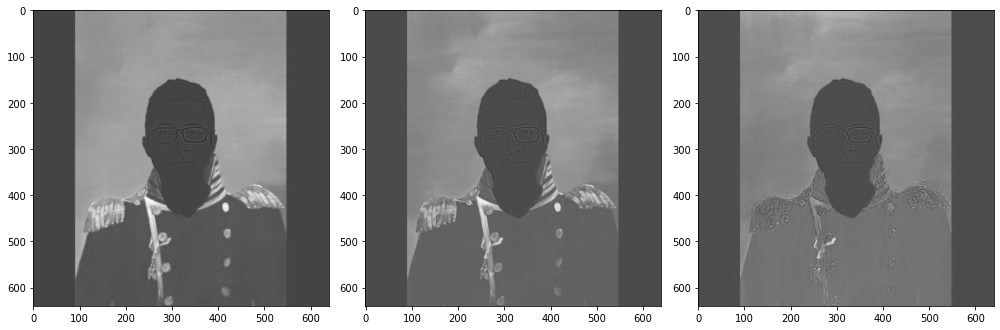

In [313]:
blended_image = new_blend_image(image_data, plots=True)

In [315]:
result_img_tensor = torch.from_numpy(np.transpose(blended_image, (2, 0, 1))).unsqueeze(0)
rgb_gradients = [gradient.numpy()[0] for gradient in sobel_filter_tensor(result_img_tensor)]
rgb_gradients = np.stack(rgb_gradients, axis=2).clip(0.0, 1.0)

# Naive Copy

In [316]:
def naive_copy(image_data):
    src = image_data['source']
    mask = image_data['mask']
    target = image_data['target'].copy()
    dims = image_data['dims']
    target[dims[0]:dims[1],dims[2]:dims[3],:] = (target[dims[0]:dims[1],dims[2]:dims[3],:] * 
                                                (1 -  np.expand_dims(mask, 2)) + src * np.expand_dims(mask, 2))
    return target

In [317]:
naive_blending = naive_copy(image_data)

In [318]:
result_img_tensor = torch.from_numpy(np.transpose(naive_blending, (2, 0, 1))).unsqueeze(0)
naive_rgb_gradients = [gradient.numpy()[0] for gradient in sobel_filter_tensor(result_img_tensor)]
naive_rgb_gradients = np.stack(naive_rgb_gradients, axis=2).clip(0.0, 1.0)

# Show results

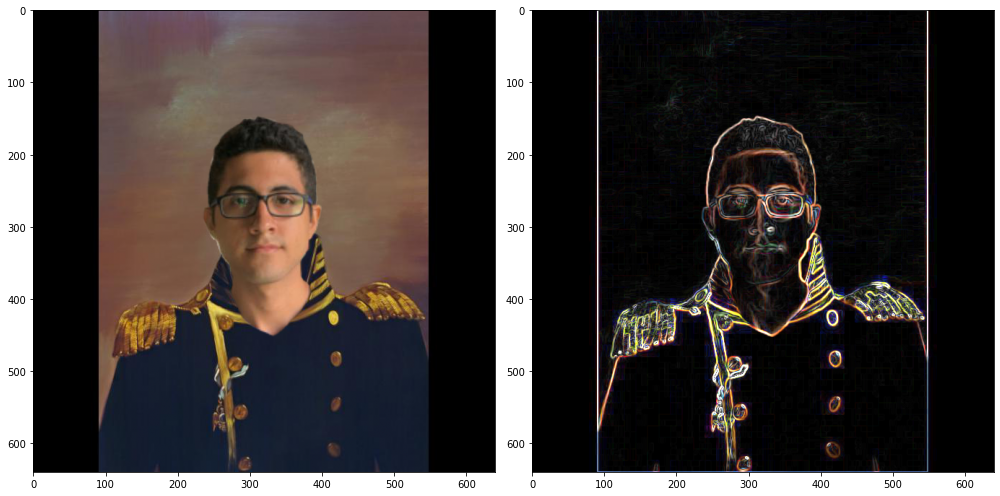

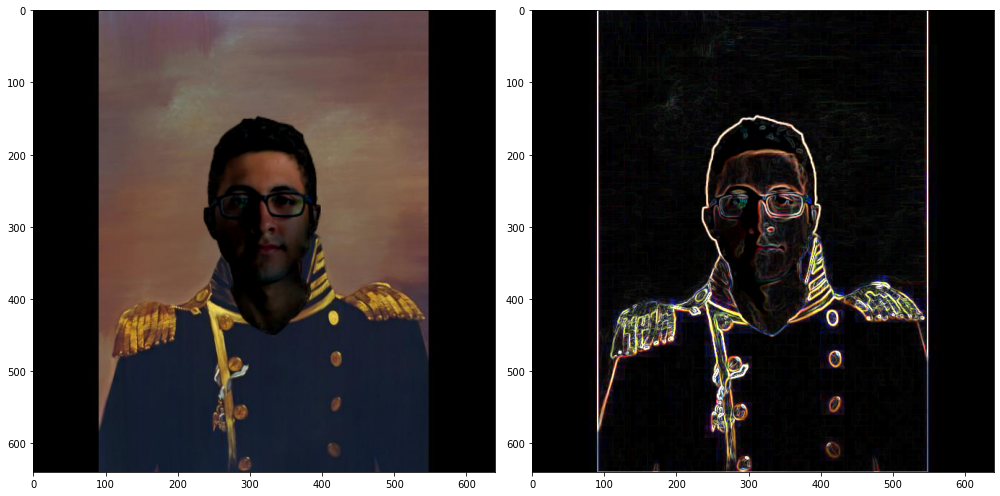

In [320]:
plots_all(naive_blending, naive_rgb_gradients)
plots_all(blended_image, rgb_gradients)